ray1      ray2      ray3      ray4      ray5     kartx     karty  \
0     -1.0  6.520244  4.611088  6.490520  4.588913  15.98891  0.265520   
1     -1.0  6.520148  4.611084  6.490616  4.588917  15.98892  0.273316   
2     -1.0  6.520138  4.611078  6.490626  4.588923  15.98892  0.275297   
3     -1.0  6.520134  4.611075  6.490630  4.588926  15.98893  0.275683   
4     -1.0  6.520125  4.611069  6.490639  4.588933  15.98893  0.275743   
...    ...       ...       ...       ...       ...       ...       ...   
2943  -1.0  8.948369 -1.000000  3.575348  2.275224 -41.65403  0.279193   
2944  -1.0  9.993568 -1.000000  3.048804  2.165597 -41.55990  0.279185   
2945  -1.0 -1.000000 -1.000000  2.685049  1.997417 -41.38477  0.279173   
2946  -1.0 -1.000000 -1.000000  2.450927  1.828517 -41.21993  0.279164   
2947  -1.0 -1.000000 -1.000000  2.280018  1.700224 -41.09257  0.279162   

          kartz       time           action  
0      3.105228   0.102285             NONE  
1      3.105127   0.204416             NONE  
2      3.105107   0.304207             NONE  
3      3.105103   0.400486             NONE  
4      3.105103   0.501602             NONE  
...         ...        ...              ...  
2943  37.803890  29.202810  LEFT_ACCELERATE  
2944  36.341170  29.301410  LEFT_ACCELERATE  
2945  34.874940  29.400590  LEFT_ACCELERATE  
2946  33.357790  29.503070       ACCELERATE  
2947  31.919370  29.600020       ACCELERATE  

[2948 rows x 10 columns]

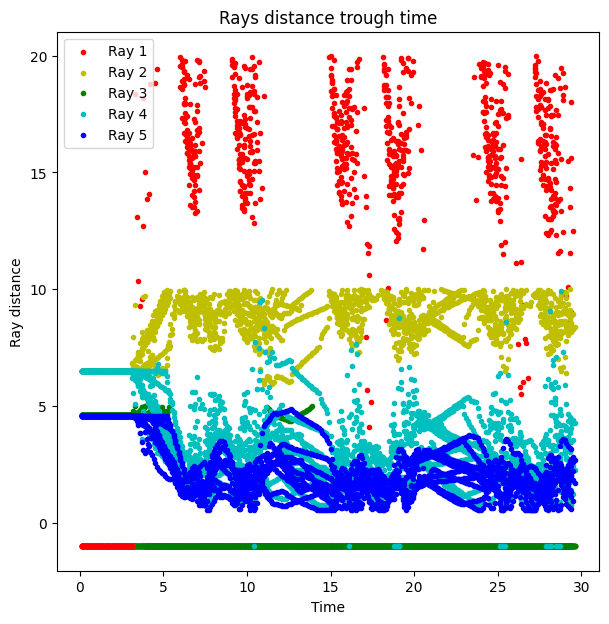

In [1]:
from ann import cost, cost_regL2, backprop, backprop2, predict, feedForward
from Utils import ExportONNX_JSON_TO_Custom, ExportAllformatsMLPSKlearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os

#Colormaps https://matplotlib.org/stable/users/explain/colors/colormaps.html#references

#Nota: para calcular la precision del modelo vamos a redondear la salida, pues nos
#interesa saber que el modelo gira a la derecha, no que esta 95% seguro de girar a la derecha

#Ejercicio 2
kartData = pd.DataFrame()

trainFiles = len(os.listdir('AAKart/ML/'))
for i in range(trainFiles):
    newKartData = pd.read_csv(f'AAKart/ML/Kart{i:02d}.csv')
    
    kartData = pd.concat([kartData, newKartData], axis=0, ignore_index=True)

display(kartData)

#Tabla posicion 2D a traves del tiempo
positionThroughTime = px.scatter_3d(kartData, x='kartx', y='kartz', z='time', color='action', 
                                    color_discrete_sequence=px.colors.qualitative.Set1)
positionThroughTime.update_traces(marker_size = 3)

positionThroughTime.update_layout(scene=dict(xaxis_title='Kart X', yaxis_title='Kart Z', zaxis_title='Time'))
positionThroughTime.update_layout(legend_title='Action')
positionThroughTime.update_layout(title='Kart 2D position through time')

positionThroughTime.show()

#Distancia de los rayos a traves del tiempo
plt.figure(figsize=(7, 7))
plt.scatter(kartData['time'], kartData['ray1'], c='r', marker='.', label="Ray 1")
plt.scatter(kartData['time'], kartData['ray2'], c='y', marker='.', label="Ray 2")
plt.scatter(kartData['time'], kartData['ray3'], c='g', marker='.', label="Ray 3")
plt.scatter(kartData['time'], kartData['ray4'], c='c', marker='.', label="Ray 4")
plt.scatter(kartData['time'], kartData['ray5'], c='b', marker='.', label="Ray 5")
plt.xlabel('Time')
plt.ylabel('Ray distance')
plt.legend()
plt.title('Rays distance trough time')
plt.show()

ray1      ray2      ray3      ray4      ray5           action
0      1.0  0.145712  0.408871  0.625336  0.938163             NONE
1      1.0  0.145688  0.408865  0.625347  0.938164             NONE
2      1.0  0.145686  0.408856  0.625348  0.938166             NONE
3      1.0  0.145685  0.408851  0.625348  0.938166             NONE
4      1.0  0.145682  0.408842  0.625349  0.938168             NONE
...    ...       ...       ...       ...       ...              ...
2943   1.0  0.742368  1.000000  0.306106  0.403238  LEFT_ACCELERATE
2944   1.0  0.999201  1.000000  0.248446  0.377893  LEFT_ACCELERATE
2945   1.0  1.000000  1.000000  0.208613  0.339009  LEFT_ACCELERATE
2946   1.0  1.000000  1.000000  0.182975  0.299960       ACCELERATE
2947   1.0  1.000000  1.000000  0.164259  0.270298       ACCELERATE

[2948 rows x 6 columns]

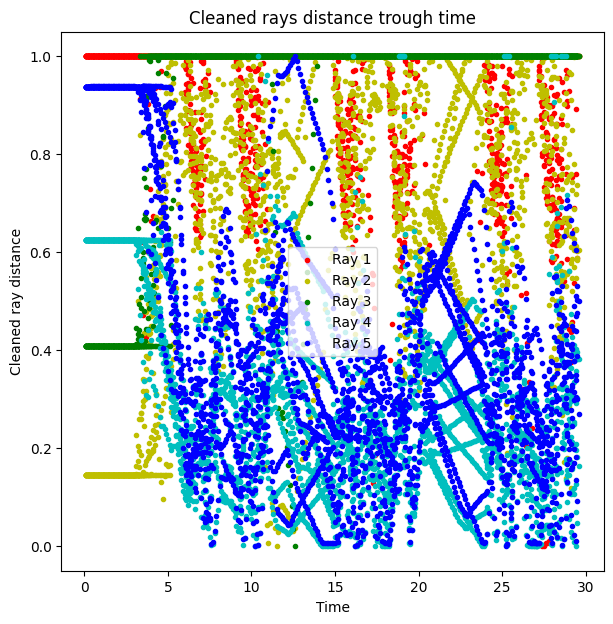

In [2]:
from sklearn.preprocessing import MinMaxScaler

#Ejercicio 3

#Kart y y time son inutiles para el modelo
cleanKartData = kartData.drop(columns=['kartx', 'karty', 'kartz', 'time'])

#Normalizar distancia de obstaculos en cada rayo
scaler = MinMaxScaler()

columnsToNormalize = ['ray1', 'ray2', 'ray3', 'ray4', 'ray5']

for column in columnsToNormalize:
    mask = (kartData[column] != -1)
    cleanKartData.loc[mask, column] = scaler.fit_transform(cleanKartData.loc[mask, [column]])
    
    #Si no hemos chocado con nada, significa que "no hay peligro", es decir, que tenemos la distancia del rayo segura
    invalidMask = (kartData[column] == -1)
    cleanKartData.loc[invalidMask, column] = 1

display(cleanKartData)

#Distancia limpia de los rayos a traves del tiempo
plt.figure(figsize=(7, 7))
plt.scatter(kartData['time'], cleanKartData['ray1'], c='r', marker='.', label="Ray 1")
plt.scatter(kartData['time'], cleanKartData['ray2'], c='y', marker='.', label="Ray 2")
plt.scatter(kartData['time'], cleanKartData['ray3'], c='g', marker='.', label="Ray 3")
plt.scatter(kartData['time'], cleanKartData['ray4'], c='c', marker='.', label="Ray 4")
plt.scatter(kartData['time'], cleanKartData['ray5'], c='b', marker='.', label="Ray 5")
plt.xlabel('Time')
plt.ylabel('Cleaned ray distance')
plt.legend()
plt.title('Cleaned rays distance trough time')
plt.show()

#Exportamos cleanKartData a Unity. Allí se programará el feedforward.

In [9]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering, KMeans
from six import StringIO
from IPython.display import Image

import pydotplus

#Ejercicio 4

#El modelo predice la action mas probable que haría el jugador grabado en kartData
encoder = OneHotEncoder(sparse_output=False)

X = cleanKartData.drop(columns=['action'])
y = encoder.fit_transform(cleanKartData[['action']])

#Separación de datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

#Perceptrón multicapa propio
print('DATOS DEL PERCEPTRÓN MULTICAPA PROPIO\n')

#Número de neuronas de cada capa. Experimentar con el número de neuronas y de capas para conseguir un mejor resultado
#A mayor número de capas, mejor capacidad para aprender representaciones jerárquicas y características abstractas de los datos.
#A mayor número de neuronas, mejor capacidad para aprender representaciones más complejas de los datos.
#Sin embargo, al aumentar estos números, puede aumentar el riesgo de sobreajuste, 
#especialmente si no hay suficientes datos de entrenamiento.
layer_sizes = [X.shape[1], 10, 10, len(kartData['action'].unique())]
epsilon = 0.12
theta_list = []

for i in range(len(layer_sizes) - 1):
    theta_list.append(np.random.rand(layer_sizes[i + 1], layer_sizes[i] + 1) * 2 * epsilon - epsilon)

iterations = 1000
lambda_ = 1
alpha = 1

for i in range(iterations):
    cost, grads = backprop(theta_list, X_train, y_train, lambda_)

    for j in range(len(theta_list)):
        theta_list[j] -= alpha * grads[j]

predictions = predict(theta_list, X_test)
accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f'Precisión del perceptrón: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
print(f'Matriz de confusión:\n {conf_matrix}')

mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
print(f'Error cuadratico medio: {mse:.2f} \n')

#MLP Classifier
print('------------------------------\n')
print('DATOS DEL MLP CLASSIFIER DE SKLEARN\n')

mlp_classifier = MLPClassifier(hidden_layer_sizes=layer_sizes[1:-2], max_iter=iterations, alpha=alpha, learning_rate_init=lambda_, random_state=8)
mlp_classifier.fit(X_train, np.argmax(y_train, axis=1))

predictions = mlp_classifier.predict(X_test)

accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f'Precisión de MLP Classifier: {accuracy * 100:.2f}%. Activation = \'relu\', Learning_rate = \'constant\'')

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
print(f'Matriz de confusión:\n {conf_matrix} \n')

mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
print(f'Error cuadratico medio: {mse:.2f} \n')

#MLP Classifier ajustada
mlp_classifier = MLPClassifier(hidden_layer_sizes=layer_sizes[1:-2], activation='logistic', learning_rate='adaptive', max_iter=iterations, alpha=alpha, learning_rate_init=lambda_, random_state=8)
mlp_classifier.fit(X_train, np.argmax(y_train, axis=1))

predictions = mlp_classifier.predict(X_test)

accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f'Precisión de MLP Classifier: {accuracy * 100:.2f}%. Activation = \'logistic\', Learning_rate = \'adaptive\'')

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
print(f'Matriz de confusión:\n {conf_matrix} \n')

mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
print(f'Error cuadratico medio: {mse:.2f} \n')

#MLP Classifier ajustada
mlp_classifier = MLPClassifier(hidden_layer_sizes=layer_sizes[1:-2], activation='tanh', learning_rate='invscaling', max_iter=iterations, alpha=alpha, learning_rate_init=lambda_, random_state=8)
mlp_classifier.fit(X_train, np.argmax(y_train, axis=1))

predictions = mlp_classifier.predict(X_test)

accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f'Precisión de MLP Classifier: {accuracy * 100:.2f}%. Activation = \'tanh\', Learning_rate = \'invscaling\'')

#MLP Classifier ajustada Matriz de confusion y MSE
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
print(f'Matriz de confusión:\n {conf_matrix} \n')

mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
print(f'Error cuadratico medio: {mse:.2f} \n')

# KNN
print('------------------------------\n')
print('DATOS DEL KNN\n')

#Valores de k a testear para el knn
knn_ks = [1, 3, 20, 50, 100]

for k in knn_ks:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, np.argmax(y_train, axis=1))

    predictions = knn_classifier.predict(X_test)

    accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
    print(f'Precisión del {k}NN: {accuracy * 100:.2f}%')

    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    print(f'Matriz de confusión:\n {conf_matrix}')

    mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
    print(f'Error cuadrático medio: {mse:.2f} \n')

#TODO: Export KNN?
#export_knn_for_unity()

# ID3 (Decision Tree)
print('------------------------------\n')
print('DATOS DEL ID3 (Decision Tree)\n')

id3_classifier = DecisionTreeClassifier()
id3_classifier.fit(X_train, np.argmax(y_train, axis=1))

predictions = id3_classifier.predict(X_test)

accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f'Precisión del ID3: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
print(f'Matriz de confusión:\n {conf_matrix}')

mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
print(f'Error cuadrático medio: {mse:.2f} \n')

dot_data = StringIO()
export_graphviz(id3_classifier, out_file=dot_data, filled=True, rounded=True, special_characters=True, 
                feature_names=['ray1', 'ray2', 'ray3', 'ray4', 'ray5'], 
                class_names=['NONE', 'ACCELERATE', 'LEFT_ACCELERATE', 'RIGHT_ACCELERATE'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))

# Random Forest
print('------------------------------\n')
print('DATOS DEL RANDOM FOREST\n')

random_forest_trees_number = 100

random_forest_classifier = RandomForestClassifier(n_estimators=random_forest_trees_number)
random_forest_classifier.fit(X_train, np.argmax(y_train, axis=1))

predictions = random_forest_classifier.predict(X_test)

accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f'Precisión del Random Forest con {random_forest_trees_number} árboles: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
print(f'Matriz de confusión:\n {conf_matrix}')

mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
print(f'Error cuadrático medio: {mse:.2f} \n')

# SVM (Support Vector Machine)
print('------------------------------\n')
print('DATOS DEL SUPPORT VECTOR MACHINE (SVM)\n')

svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, np.argmax(y_train, axis=1))

predictions = svm_classifier.predict(X_test)

accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f'Precisión del SVM: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
print(f'Matriz de confusión:\n {conf_matrix}')

mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
print(f'Error cuadrático medio: {mse:.2f} \n')

# K-Means
print('------------------------------\n')
print('DATOS DEL K-MEANS\n')

#Valores de k a testear para el k-means
kmeans_ks = range(1,5)

for k in kmeans_ks:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=4)
    kmeans.fit(X_train)

    predictions = kmeans.predict(X_test)

    accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
    print(f'Precisión del {k}-means: {accuracy * 100:.2f}%')

    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    print(f'Matriz de confusión:\n {conf_matrix}')

    mse = mean_squared_error(np.argmax(y_test, axis=1), predictions)
    print(f'Error cuadrático medio: {mse:.2f} \n')




DATOS DEL PERCEPTRÓN MULTICAPA PROPIO

Precisión del perceptrón: 51.83%
Matriz de confusión:
 [[382   0   0   0]
 [326   0   0   0]
 [ 14   0   0   0]
 [ 15   0   0   0]]
Error cuadratico medio: 0.70 

------------------------------

DATOS DEL MLP CLASSIFIER DE SKLEARN

Precisión de MLP Classifier: 51.83%. Activation = 'relu', Learning_rate = 'constant'
Matriz de confusión:
 [[382   0   0   0]
 [326   0   0   0]
 [ 14   0   0   0]
 [ 15   0   0   0]] 

Error cuadratico medio: 0.70 

Precisión de MLP Classifier: 51.83%. Activation = 'logistic', Learning_rate = 'adaptive'
Matriz de confusión:
 [[382   0   0   0]
 [326   0   0   0]
 [ 14   0   0   0]
 [ 15   0   0   0]] 

Error cuadratico medio: 0.70 

Precisión de MLP Classifier: 51.97%. Activation = 'tanh', Learning_rate = 'invscaling'
Matriz de confusión:
 [[382   0   0   0]
 [325   1   0   0]
 [ 14   0   0   0]
 [ 15   0   0   0]] 

Error cuadratico medio: 0.70 

------------------------------

DATOS DEL KNN

Precisión del 1NN: 67.16%

------------------------------

DATOS DEL RANDOM FOREST

Precisión del Random Forest con 100 árboles: 72.32%
Matriz de confusión:
 [[287  83   8   4]
 [ 87 238   0   1]
 [  7   0   7   0]
 [ 10   4   0   1]]
Error cuadrático medio: 0.51 

------------------------------

DATOS DEL SUPPORT VECTOR MACHINE (SVM)

Precisión del SVM: 73.95%
Matriz de confusión:
 [[354  28   0   0]
 [135 191   0   0]
 [ 14   0   0   0]
 [ 12   3   0   0]]
Error cuadrático medio: 0.46 

------------------------------

DATOS DEL K-MEANS

Precisión del 1-means: 51.83%
Matriz de confusión:
 [[382   0   0   0]
 [326   0   0   0]
 [ 14   0   0   0]
 [ 15   0   0   0]]
Error cuadrático medio: 0.70 

Precisión del 2-means: 45.73%
Matriz de confusión:
 [[298  84   0   0]
 [287  39   0   0]
 [  0  14   0   0]
 [ 15   0   0   0]]
Error cuadrático medio: 0.71 

Precisión del 3-means: 35.14%
Matriz de confusión:
 [[ 93 216  73   0]
 [150 152  24   0]
 [  0   0  14   0]
 [  1  14   0   0]]
Error cuadrático medio: 1.01 

Pr

# Resultados
Precisión del perceptrón: 51.83%

Precisión de MLP Classifier: 51.83%. Activation = 'relu', Learning_rate = 'constant'

Precisión de MLP Classifier: 51.83%. Activation = 'logistic', Learning_rate = 'adaptive'

Precisión de MLP Classifier: 51.97%. Activation = 'tanh', Learning_rate = 'invscaling'

Precisión del 1NN: 67.16%

Precisión del 3NN: 73.00%

Precisión del 20NN: 75.58%

Precisión del 50NN: 76.39%

Precisión del 100NN: 76.26%

Precisión del ID3: 65.67%

Precisión del Random Forest con 100 árboles: 72.32%

Precisión del SVM: 73.95%

Precisión del 1-means: 51.83%

Precisión del 2-means: 45.73%

Precisión del 3-means: 35.14%

Precisión del 4-means: 23.34%